**Project Goal: This projects implements a compact version of the DETR(DEtection TRansfomer) architecture, called Tiny-DETR for pedestrian detection.**

- **Build an end-to-end transformer-based object detector.**
- **Replace traditional post-processing (NMS) with Hungarian bipartite matching.**
- **Analyze how architectural choices (depth, backbone, query count, augmentation) affect performance under a small-dataset regime**
- **Evaluate performance using mAP@0.5 and study generalization behavior.**

**Dataset Used:**
- **This project uses the PennFudanPed dataset.**

**All details are incuded in the report**

## Necessary Imports

In [ ]:
pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 15.5 MB/s eta 0:00:00


In [ ]:
import os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import cv2 as cv

import torch
import torchvision.transforms as T
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision.models import MobileNet_V2_Weights
from torchvision.models import ResNet18_Weights

from scipy.optimize import linear_sum_assignment

from torchmetrics.detection.mean_ap import MeanAveragePrecision

import pickle

import time

import random

## Important Configurations

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
seed = 40
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Dataset & Setup

### Important Functions

In [ ]:
def read_splits(split_path):
  """
  Read the split txt files.
  These are three files that includes the image names
  for training, testing and validation.

  Parameters
  ----------
  split_path: str
    The path to the folder that contains the split files.


  Returns
  -------
  train: ndarray
    The list of image names for training.
  test: ndarray
    The list of image names for testing.
  val: ndarray
    The list of image names for validation.
  """
  train = []
  test = []
  val = []
  for filename in os.listdir(split_path):
    if filename.endswith(".txt"):
      path = split_path + filename
      with open(path, 'r') as f:
        lines = f.readlines()
      lines = [line.strip() for line in lines]
      if filename == "train.txt":
        train = lines
      elif filename == "test.txt":
        test = lines
      elif filename == "val.txt":
        val = lines

  return (np.array(train), np.array(test), np.array(val))

def read_img(data_path, train, test, val):
  """
  Read the images from the data path.
  Resize the images to 512x512.
  Store the images in a list.

  Parameters
  ----------
  data_path: str
    The path to the folder that contains the images.

  train: nndarray
    The list of image names for training.

  test: ndarray
    The list of image names for testing.

  val: ndarray
    The list of image names for validation.

  Returns
  -------
  X_train: ndarray
    The array of images for training.

  X_test: ndarray
    The array of images for testing.

  X_val: ndarray
    The array of images for validation.
  """
  X_train = []
  X_test = []
  X_val = []

  def helper(filenames):
    imgs = []
    for filename in filenames:
      img = cv.imread(data_path + filename)
      img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
      img = cv.resize(img, (512, 512))
      imgs.append(img)
    return imgs

  X_train = helper(train)
  X_test = helper(test)
  X_val = helper(val)

  return np.array(X_train), np.array(X_test), np.array(X_val)

# Reading the boxes
def read_boxes(box_path, train, test, val):
  """
  Read the labels (detection box coordinates) from txt files.
  Modify the labels to fit the resize of the images. (512x512)

  Parameters
  ----------
  box_path: str
    The path to the folder that contains the labels.

  train: ndarray
    The list of image names for training.

  test: ndarray
    The list of image names for testing.

  val: ndarray
    The list of image names for validation.


  Returns
  -------
  y_train: ndarray
    The array of labels for training.

  y_test: ndarray
    The array of labels for testing.

  y_val: ndarray
    The array of labels for validation.
  """
  y_train = []
  y_test = []
  y_val = []

  def helper(filenames):
    boxes = []
    for filename in filenames:
      info = []
      path = box_path + filename.split(".")[0] + ".txt"
      with open(path, "r") as f:
        width_scale = 1
        height_scale = 1
        for line in f:
          if line.startswith("Image size (X x Y x C) :"):
            dim = [int(x) for x in line.split() if x.isdigit()] # [Width, Height, Channel]
            width_scale = 512 / dim[0]
            height_scale = 512 / dim[1]
          elif line.startswith("Bounding box"):
            coords = [int(x) for x in line.replace("("," ").replace(")"," ").replace(",", " ").split() if x.isdigit()] # [obj_number, X_min, y_min, X_max, y_max]
            x_min = coords[1] * width_scale
            y_min = coords[2] * height_scale
            x_max = coords[3] * width_scale
            y_max = coords[4] * height_scale
            info.append([x_min, y_min, x_max, y_max])
        boxes.append(np.array(info))

    return boxes

  y_train = helper(train)
  y_test = helper(test)
  y_val = helper(val)

  return (y_train, y_test, y_val)

def show_images(X, y, n, n_cols=4, figsize=(15,10), save=False, name=""):
  """
  To show the images in the dataset as a grid of n images.

  Parameters
  ----------
  X:

  n: int
    The number of images to show.

  n_cols: int, default = 4
    The number of columns in the grid.

  figsize: tuple, default = (10,5)
    The size of the figure.

  """
  n_cols = n_cols
  n_rows = int(np.ceil(n / n_cols))
  fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
  axes = axes.flatten()
  for i in range(n_rows):
    for j in range(n_cols):
      index = i * n_cols + j
      ax = axes[index]
      if index > n - 1:
        break

      img = X[index]
      boxes = y[index]

      for box in boxes:
        box = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], edgecolor='r', facecolor='none')
        ax.add_patch(box)
      ax.imshow(img)
      ax.axis("off")

  if(n % n_cols != 0):
    for i in range(n_cols * n_rows):
      if i >= n:
        fig.delaxes(axes[i])

  if save:
    plt.savefig(image_output_path + name + ".jpg", dpi=300)


def clean_gpu():
  # GPU memory cleanup
  import gc
  gc.collect()
  if torch.cuda.is_available():
      torch.cuda.empty_cache()

### Data Loading

In [ ]:
# Connecting to google drive -- UNCOMMENT IF NEEDED
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
main_path = "./drive/Othercomputers/My Laptop/Assignment4/" # THIS SHOULD BE CHANGED

data_path = main_path + "PennFudanPed/Pedestrian/"
split_path = main_path + "splits/"

model_output_path = main_path + "models/"
image_output_path = main_path + "report_imgs/"

In [ ]:
# Read the split files
train, test, val = read_splits(split_path)

In [ ]:
# Reading the images
X_train, X_test, X_val = read_img(data_path, train, test, val) # 4-5min

In [ ]:
y_train, y_test, y_val = read_boxes(data_path, train, test, val) #

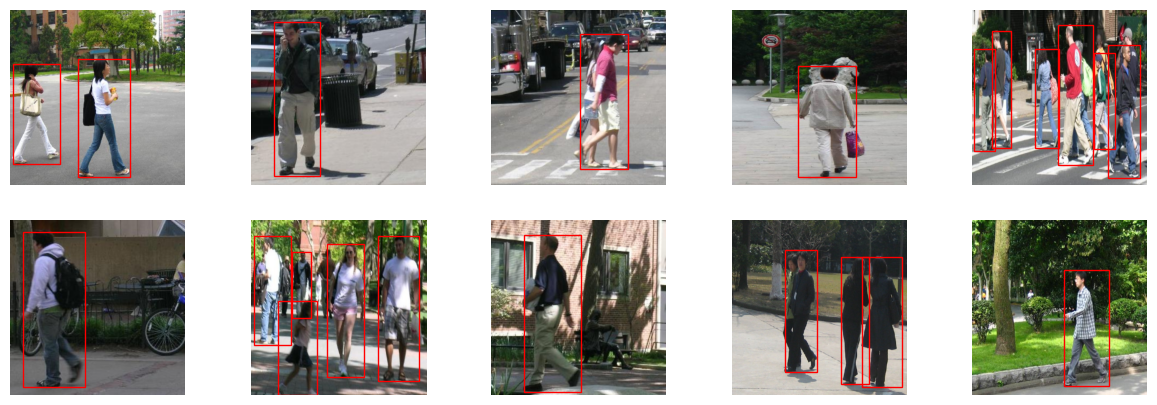

In [ ]:
show_images(X_train, y_train, 10, 5, figsize=(15,5))

- **The images are full of pedestrians.**
- **The pedestrians are mostly shown full-body, facing the side view more than backward or forward. Moreover, there is not a lot of scene diverity.**
- **The pedestrians occupy a good portion of the image as well.**
- **The are a lot of similarities in the image environment making it a simple dataset. This is helpful for the simplified Tiny-DETR model. In fact, it potentially makes it easier for the match prediction using the Hungarian matching later on.***

### Data Augmentation - Offline

In [ ]:
X_train.shape

(118, 512, 512, 3)

In [ ]:
def flip(X, y):
  """
  Apply horizontal flipping to images and update their
  corresponding bounding box annotations.

  Parameters
  ----------
  X: ndarray
    Input images of shape (N, H, W, C)

  y: list
    List of length N containing the bounding box annotations
    for each image. Each element is a 2D array of shape (N_objects, 4) in
    (x_min, y_min, x_max, y_max) format.

  Returns
  -------
  X_flipped: ndarray
    The flipped images of shape (N, H, W, C)

  y_flipped: list
    Updated bounding box annotations for the flipped images.
  """
  w = X.shape[2]
  X_flipped = X[:, :, ::-1, :].copy()
  y_flipped = []
  for boxes in y:
    info = []
    for x_min, y_min, x_max, y_max in boxes:
      new_x_min = w - 1 - x_max
      new_x_max = w - 1 - x_min
      info.append([new_x_min, y_min, new_x_max, y_max])
    y_flipped.append(np.array(info))

  return X_flipped, y_flipped

def color_jitter(X):
  """
  Apply color jitter to images.
  It randomly adjusts brightness, contrast, saturation, and hue.
  It does not change the spatial structures.

  Parameters
  ----------
  X: ndarray
    Input images of shape (N, H, W, C)


  Returns
  -------
  X_aug: ndarray
    Color jittered images with the same input shape.
  """
  color_jitter = T.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.25, hue=0.2)
  X_torch = torch.from_numpy(X).permute(0, 3, 1, 2).float() / 255
  X_aug = torch.stack([color_jitter(img) for img in X_torch])
  X_aug = X_aug.clamp(0, 1)
  X_aug = (X_aug.numpy() * 255).transpose(0, 2, 3, 1).astype(np.uint8)
  return X_aug

def data_augmentation(X, y):
  """
  Apply horizontal flipping and color jittering to images and
  update their corresponding bounding box annotations.

  Parameters
  ----------
  X: ndarray
    Input images of shape (N, H, W, C)

  y: list
    List of length N containing the bounding box annotations
    for each image

  Returns
  -------
  X_aug:
  """
  # X: (n_samples, H, W, C)
  # y: list of n_samples. each entry:
  # Horizontal + Vertical Flips
  X_flipped, y_flipped = flip(X, y)

  # Color jittering
  X_jittered = color_jitter(X)

  # Concatenation
  X_aug = np.concatenate((X, X_flipped, X_jittered), axis=0)
  y_aug = y + y_flipped + y
  return X_aug, y_aug

In [ ]:
X_train_aug, y_train_aug = data_augmentation(X_train, y_train)

In [ ]:
print(X_train_aug.shape, len(y_train_aug))

(354, 512, 512, 3) 354


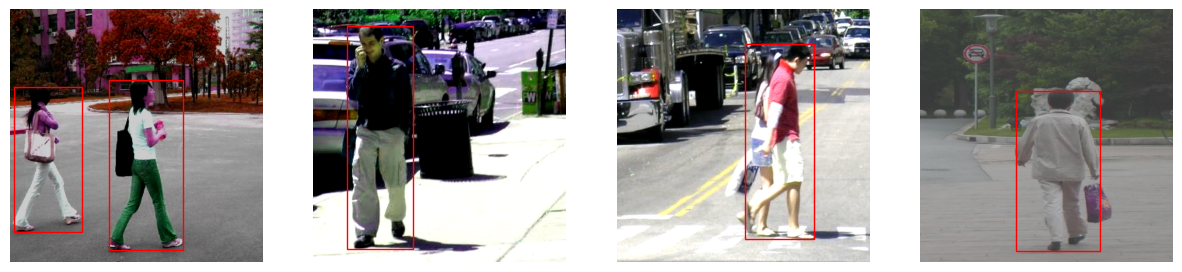

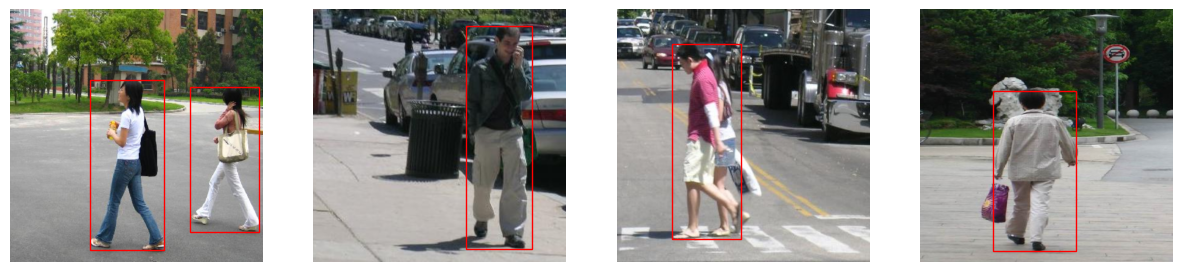

In [ ]:
show_images(X_train_aug[236:], y_train_aug[236:], 4) # Jittered
show_images(X_train_aug[118:], y_train_aug[118:], 4) # Flipped

### Data Normalization

In [ ]:
mean = np.array([0.485, 0.456, 0.406]).reshape(1, 3, 1, 1) # https://docs.pytorch.org/vision/0.9/transforms.html
std = np.array([0.229, 0.224, 0.225]).reshape(1, 3, 1, 1)

def normalize(X):
  """
  Normalize the images according to the mean and standard
  deviation of the dataset.


  Parameters
  ----------
  X: ndarray
    The array of images.
    Shape: (N_samples, Height, Width, Channel)


  Returns
  -------
  X_norm: ndarray
    The normalized array of images.
    Shape: (N_samples, Channel, Height, Width)
  """
  X_norm = X.transpose(0, 3, 1, 2) / 255
  X_norm = (X_norm - mean) / std

  return X_norm

def normalize_box(y, width, height):
  """
  Convert the boxes from x_min, y_min, x_max, y_max to cx cy w h

  Normalize the data.


  Parameters
  ----------
  y: ndarray
    The array of labels.

  width: int
    The width of the image.

  height: int
    The height of the image.



  Returns
  -------
  y_norm: ndarray
    The normalized array of labels.
  """
  y_norm = []

  for boxes in y:

    if boxes.size == 0:
      y_norm.append(boxes)

    else:
      center_x = ((boxes[:, 0] + boxes[:, 2]) / 2) / width # PAGE 5 OF THE RESEARCH PAPER
      center_y = ((boxes[:, 1] + boxes[:, 3]) / 2) / height

      w = (boxes[:, 2] - boxes[:, 0]) / width
      h = (boxes[:, 3] - boxes[:, 1]) / height

      info = np.stack((center_x, center_y, w, h), axis=1)
      y_norm.append(info)

  return y_norm



#### Original Data Normalization

In [ ]:
X_train_norm = normalize(X_train)
X_test_norm = normalize(X_test)
X_val_norm = normalize(X_val)

In [ ]:
y_train_norm = normalize_box(y_train, 512, 512)
y_test_norm = normalize_box(y_test, 512, 512)
y_val_norm = normalize_box(y_val, 512, 512)

#### Augmented Data Normalization

In [ ]:
X_train_aug_norm = normalize(X_train_aug)

In [ ]:
y_train_aug_norm = normalize_box(y_train_aug, 512, 512)

### Data Preparation for Model Training

In [ ]:
X_train_norm = torch.from_numpy(X_train_norm).float()
X_test_norm = torch.from_numpy(X_test_norm).float()
X_val_norm = torch.from_numpy(X_val_norm).float()

X_train_aug_norm = torch.from_numpy(X_train_aug_norm).float()

In [ ]:
def prepare_targets(y):
  """
  Prepare the targets for the model.

  Parameters
  ----------
  y: ndarray
    The array of labels.

  Return
  ------
  targets: list of dict
    labels (torch.Tensor): A tensor of shape (N_classes,) containing
    the class indices (0, 1, 2, ..., N_classes-1).

    boxes (torch.Tensor): a tensor of shape (N_classes, 4) containing
    the bounding box coordinates.
  """
  targets = []
  for boxes in y:
    sample_boxes = torch.as_tensor(boxes, dtype=torch.float32).to(device)
    n_objects = sample_boxes.shape[0] # Number of objects in the current image
    # All actual objects belong to class 0 (pedestrian) since n_classes is set to 1 in the model.
    labels = torch.zeros(n_objects, dtype=torch.long).to(device)
    targets.append({
        "labels":labels,
        "boxes":sample_boxes
    })
  return targets

In [ ]:
y_train_norm = prepare_targets(y_train_norm)
y_test_norm = prepare_targets(y_test_norm)
y_val_norm = prepare_targets(y_val_norm)

y_train_aug_norm = prepare_targets(y_train_aug_norm)

### DataLoader

In [ ]:
def get_batches(X, y, batch_size, shuffle=True):
  """
  Generate batches of data using the yield keyword.
  The yield keywod was used to make it look like the original
  dataloader. Dataloader cannot be used here because of the y
  list of dictionaries.

  Parameters
  ----------
  X: ndarray
    The array of images.

  y: ndarray
    The array of labels.

  batch_size: int
    The size of each batch.

  Return
  ------
  batch_X: ndarray
    The array of images in the batch.

  batch_y: ndarray
    The array of labels in the batch.
  """
  n_samples = len(X)
  indices = np.random.permutation(n_samples) if shuffle else np.arange(n_samples)
  for i in range(0, n_samples, batch_size):
    batch_indices = indices[i : i + batch_size]
    batch_X = X[batch_indices]
    batch_y = [y[j] for j in batch_indices]
    yield batch_X, batch_y

## Tiny-DETR

**Positional Encoding Coding Logic:**
- **Create a 4 array of size $B\times \frac{C}{2} \times 1 \times W$ and calculate $PE_x$.**
- **Make that array the same across all rows -> $B\times \frac{C}{2} \times H \times W$**
- **Create a 4D array of size $B\times \frac{C}{2} \times H \times 1$ and calculate $PE_y$.**
- **Make that array the same across all columns -> $B\times \frac{C}{2} \times H \times W$**
- **PE = $[PE_y || PE_x]$**

### Tiny-DETR Implementation

In [ ]:
class TinyDETR(nn.Module):
  """
  A lightweight implementation of the DETR (DEtection TRansformer) architecture.
  This model follows the same essential components of the original DETR by
  combining a pretrained CNN backbone with a transformer encoder-decoder architecture.

  Parameters
  ----------
  backbone: str
    Backbone network used for feature extraction.
    - MobileNetV2
    - ResNet18

  hidden_size: int
    Dimension of the feature vectors inside the Transformer.

  n_enc_layer: int
    Number of encoder layers

  n_dec_layer: int
    Number of decoder layers

  n_query: int
    Number of learnable object queries

  n_classes: int
    Number of target classes (without no-object)


  Attributes
  ----------
  training_loss: list
    Stores training loss for each epoch.

  validation_loss: list
    Stores validation loss for each epoch.

  validation_mAP: list
    Stores validation mAP for each epoch.

  backbone: nn.Module
    The backbone network used for feature extraction.

  pre_encoder: nn.Module
    Pre-training 1x1 Convolutional Neural Network.
    It is used to reduce the dimension before the feeding
    the data to the Transformer.

  encoder: nn.Module
    The Transformer encoder.

  decoder: nn.Module
    The Transformer decoder.

  obj_queries: nn.Module
    The learnable object queries.

  class_FNN: nn.Module
    The final feed-forward neural network for classification.

  box_FNN: nn.Module
    The final feed-forward neural network for bounding box regression.

  """
  def __init__(self, backbone, hidden_size, n_enc_layer, n_dec_layer, n_query, n_classes):
    super(TinyDETR, self).__init__()

    self.training_loss = []
    self.validation_loss = []
    self.validation_mAP = []

    # Backbone
    if backbone == "MobileNetV2":
      self.backbone = models.mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT).features
      in_channels = 1280
    elif backbone == "ResNet18":
      self.backbone = nn.Sequential(*list(models.resnet18(weights=ResNet18_Weights.DEFAULT).children())[:-2])
      in_channels = 512 # Not related to the width of the image. It is a coincidence

    # Pre-training 1x1 Convolutional Neural Network - Page 6 of the research paper
    self.pre_encoder = nn.Conv2d(in_channels, hidden_size, kernel_size=1)

    # Encoder Transformer
    self.encoder = nn.TransformerEncoder(
        nn.TransformerEncoderLayer(d_model = hidden_size, nhead = 8, batch_first=True),
        num_layers = n_enc_layer
    )

    # Decoder Transformer
    self.decoder = nn.TransformerDecoder(
        nn.TransformerDecoderLayer(d_model = hidden_size, nhead = 8, batch_first=True),
        num_layers = n_dec_layer
    )

    # Queries
    self.obj_queries = nn.Embedding(n_query, hidden_size) # Shape: [Batch, n_query, hidden_size]

    # Prediction Heads - Final FFN
    self.class_FNN = nn.Linear(hidden_size, n_classes + 1) # The +1 for the no object

    # "3-layer perceptron with ReLU activation function" Page 7 -- Layer dimensions are the same dimensions followed in the original DETR, from github
    self.box_FNN = nn.Sequential(
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, 4),
    )

  def forward(self, X):
    """
    Apply forward propagation for the Tiny-DETR model.

    Parameters
    ----------
    X: ndarray
      The array of images.
      Shape: (B, C, H, W)

    Returns
    -------
    dict
      Dictionary containing:
      - pred_logits: torch.Tensor of shape (B, Q, n_classes + 1)
      which have classification logits for each object query.
      - pred_boxes: torch.Tensor of shape (B, Q, 4)
      which have predicted bounding boxes for each object query.

    """
    # Backbone
    features = self.backbone(X)

    # Pre-encoder
    features = self.pre_encoder(features)

    #Positional Encoding
    B, C, H, W = features.shape
    features = features.permute(0, 2, 3, 1).reshape(B, H * W, C) # [B, H * W, C]
    PE = self.positional_encoding(B, C, H, W) # [B, H * W, C]
    result = features + PE

    # Transformer
    # Encoder
    encoder_result = self.encoder(result)
    # Decoder
    queries = self.obj_queries.weight.unsqueeze(0).expand(B, -1, -1)
    decoder_result = self.decoder(queries, encoder_result)

    # FNN
    class_result = self.class_FNN(decoder_result) # [B, Q, n_classes + 1]
    box_result = self.box_FNN(decoder_result).sigmoid() # sigmoid for the range [0, 1] - similar to the original code

    # Each object query outputs a vector of logits (one for every class along with the background class)
    return {"pred_logits": class_result, "pred_boxes":box_result}


  def positional_encoding(self, B, C, H, W): # Consider putting outside of the class to save time
    """
    Calculate the positional encoding for the Tiny-DETR model.

    Information that were used for vectorizing the code:
    - Positions (pos) are the same across the channels. This helps in creating the
    position 4d array across the width only for PE_x and height only for PE_y.
    Then the final result is just expanded across the channels and batches.
    - Position encoding values are the same across all batches. This helps in
    creating the position 4d array across the batches.
    - i values are the same across all dimensions (H & W). Thos helps in
    creating the i 4d array across the channels only and then expanding
    across batches and dimensions.

    Parameters
    ----------
    B: int
      The batch size.

    C: int
      The number of channels out of the pre-encoder
      convolutional layer.

    H: int
      The height of the image.

    W: int
      The width of the image.


    Returns
    -------
    PE: ndarray
      The positional encoding for the Tiny-DETR model.
      Shape: (B, H * W, C)
    """
    new_C = C // 2
    pos_arr_x = torch.arange(W, device = device).float()      # [W] array
    i_arr = (torch.arange(C/2, device = device) // 2).float().view(1, new_C, 1, 1) # [C/2] array -- divided by two for same frequency for sin/cos pairs -> Shape: [1, C / 2, 1, 1]

    # PE_x
    pos_arr_x = pos_arr_x.view(1, 1, 1, W) # Shape: [1, 1, 1, W]
    PE_x = pos_arr_x / torch.pow(10000, 2 * i_arr / new_C)
    PE_x[:, 0::2, :, :] = torch.sin(PE_x[:, 0::2, :, :].clone())
    PE_x[:, 1::2, :, :] = torch.cos(PE_x[:, 1::2, :, :].clone())

    PE_x = PE_x.expand(B, -1, H, -1) # Shape: [B, C / 2, H, W]

    # PE_y
    pos_arr_y = torch.arange(H, device=device) # [H] array
    pos_arr_y = pos_arr_y.view(1, 1, H, 1).float() # Shape: [1, 1, H, 1]

    PE_y = pos_arr_y / torch.pow(10000, 2 * i_arr / new_C)
    PE_y[:, 0::2, :, :] = torch.sin(PE_y[:, 0::2, :, :].clone())
    PE_y[:, 1::2, :, :] = torch.cos(PE_y[:, 1::2, :, :].clone())


    PE_y = PE_y.expand(B, -1, -1, W) # Shape: [B, C / 2, H, W]

    # Concatenation
    PE = torch.cat([PE_y, PE_x], dim=1) # Shape: [B, C, H, W]

    return PE.permute(0, 2, 3, 1).reshape(B, H * W, C) # Shape: [B, H * W, C]

### Important Functions

#### Hungarian Cost Matrix

In [ ]:
def hungarian_cost_matrix(outputs, targets):
  """
  Calculate the cost matrix for the Hungarian algorithm.

  NOTE: For loops were going to be used at first. However, I liked the "flattened"
  idea inspired from the original code that's why I have used it here as well.

  Algorithm
  ---------
  The goal is to map the predicted classes to the corresponding
  existing ones in the actual image. This is achieved through
  calculating the cost matrix. The cost matrix is of shape: [batch * queries, sum(N_b)].
  where N_b is the number of classes present in the current image (it varies).

    1- Apply softmax to the predicted logits.
    2- Flatten the probability matrix to [B * Q, n_classes + 1] for computational efficiencies
    3- Create a 1D array of size sum(N_b) whose values are the actual class labels.
       This serves as column indices to the probability array.
    4- Create a 2D matrix of shape [batch * queries, sum(N_b)] whose values tell what
       the probability is if query i matches target j.
    5- Calcualte the cost.
    6- Following the same approach, calculate the cost matrix for the boxes.
    7- Sum both matrices together to have the final cost matrix.
    8- Use Linear sum assignment for the rest of the Hungarian algorithm steps.
    9- Return the indices.

  Parameters
  ----------
  outputs: dict
    The output of the Tiny-DETR model.

  targets: dict
    The actual class labels and bounding boxes.


  Return
  ------
  indices: list of tuples
    The indices from the Hungarian algorithm.
    The length of list is batch. Each entry represents
    information about a single image.

    Each entry has two tuples. The first tuple represents
    a query list and the second tuple represents a target list.
    The length of each tuple is the number of objects in the real
    image.

    [
      (
        [q_0, ..., q_N], [t_1, ..., t_N]
      ),
      ...
      ...
      ...
    ] for N being the number of groud-truth objects in the image.

  """
  pred_logits = outputs["pred_logits"] # [batch, queries, n_classes + 1]
  pred_boxes = outputs["pred_boxes"]   # [batch, queries, 4]
  batch, query, n_classes = outputs["pred_logits"].shape

  pred_logits = pred_logits.flatten(0, 1).softmax(-1) # [batch * queries, n_classes + 1]
  pred_boxes = pred_boxes.flatten(0, 1)               # [batch * queries, 4]

  # 1D array whose values are the actual class labels. The latter serve as column indices to the pred_logits array.
  actual_ids = torch.cat([target["labels"] for target in targets])
  actual_boxes = torch.cat([target["boxes"] for target in targets])

  #cost_class = -torch.log(pred_logits[torch.arange(batch * query), actual_ids])
  cost_class = -torch.log(pred_logits[:, actual_ids] + 1e-9)
  cost_box = torch.cdist(pred_boxes, actual_boxes, p=1)

  cost = (1 * cost_class + 5 * cost_box).view(batch, query, -1).cpu()

  n_actual_obj = [len(target["labels"]) for target in targets] # [N_0, N_1, ..., N_b-1]
  # Linear sum assignment takes the 2D cost matrix for each image to return the corresponding indices
  indices = [linear_sum_assignment(c[i]) for i, c in enumerate(cost.split(n_actual_obj, -1))]
  result = [(torch.as_tensor(x, dtype=torch.long), torch.as_tensor(y, dtype=torch.long)) for x, y in indices] # from numpy to torch again

  return result


#### Loss Function

**Goal:**
- **Calculate the loss for the classification.**
- **Calculate the loss for the boxes.**

**Classification Loss:**
- **For each query, I will put the labels class for it and then use class as an index to pick that query's probability and calculate the cross entropy using the whole row ofc of that query.**

In [ ]:
def calculate_loss(indices, outputs, targets, lamb, alpha):
  """
  Classification Loss: The goal is to have a cross entropy matrix of shape (B, Q)
  In this matrix, for each batch or each row represents the cross entropy of this query
  predicting the target label. So this needs the logit of this query predicting this class
  and all logits of this query for all classes (cross-entropy formula).
  As a result, we create a matrix of (B, Q) having the no-object class to solve for the unmatched
  problem. Then, using the indices from the hungarian loss, we put the groundtruth label through
  using the target index in the indices list. and the cross entropy matrix is ready. Afterwards,
  we use the F cross entropy function to calculate that.

  Parameters
  ----------
  indices: list of tuples
    The indices from the Hungarian algorithm.

  outputs: dict
    The returned dictionary output from the forward propagation
    of the Tiny-DETR model.

  targets: list of dict
    Ground-truth annotations for each image in the batch.
    Each dictionary has:
    - labels: torch.Tensor of shape (N_b,)
    - boxes: torch.Tensor of shape (N_b,4)

  lamb: float
    Weighting coefficient applied to the bounding box L1 loss

  alpha: float
    Weighting coefficient applied to the no-object class to reduce
    its dominance during training.


  Returns
  -------
  total_loss: torch.Tensor
    Scalar tensor representing the total loss
  """
  pred_logits = outputs["pred_logits"]
  pred_boxes = outputs["pred_boxes"]
  B, Q, n_classes_plus = pred_logits.shape
  no_obj = n_classes_plus - 1

  cross_entropy = torch.full((B, Q), no_obj, dtype=torch.long, device=device)

  total = torch.tensor(0.0, device=device) # Changed to 0.0 to initialize as float
  N_b = 0

  for b in range(B):
    query, target = indices[b]
    actual_labels = targets[b]["labels"].to(device)
    actual_boxes = targets[b]["boxes"].to(device)
    # Classification Loss Part 1
    cross_entropy[b, query] = actual_labels[target]

    # Box Loss Part 1
    if len(query) > 0:
      pred = pred_boxes[b, query]
      total += torch.abs(pred - actual_boxes[target]).sum()
      N_b += len(query)

  # Classifiaction Loss Part 2
  weight = torch.ones(n_classes_plus, device=device) # [ C + 1 ]
  weight[no_obj] = alpha
  classification_loss = F.cross_entropy(pred_logits.permute(0, 2, 1), cross_entropy, weight)

  # Box Loss Part 2
  if N_b > 0:
    box_loss = total / (N_b * 4)
  else:
    #box_loss = torch.tensor(0.0, device=device, requires_grad=True) # Changed to 0.0
    box_loss = pred_boxes.sum() * 0.0

  # Total Loss
  total_loss = classification_loss + lamb * box_loss

  return total_loss

#### mAP Calculation

In [ ]:
def to_device(batch_y):
  """
  Move the batch_y to the same device as the model.
  """
  return [{k: torch.as_tensor(v).to(device) if isinstance(v, (np.ndarray, torch.Tensor)) else v for k, v in t.items()} for t in batch_y]

In [ ]:
def helper_get_mAP(metric, batch_X, batch_y, outputs, filter_coef=0.2):
  """

  """
  logits = outputs["pred_logits"]
  probs = torch.softmax(logits, dim=-1)
  fg_probs = probs[:, :, :-1]
  scores, labels = fg_probs.max(dim=-1)
  preds = []
  for i in range(len(batch_X)):
      filter = scores[i] > filter_coef
      # labels, scores, and boxes are key names required by mAP@0.5
      preds.append({
          "labels": labels[i][filter],
          "boxes":outputs["pred_boxes"][i][filter],
          "scores":scores[i][filter] # Important to evaluate the confidence of the predictions.
      })

  metric.update(preds, batch_y)
  return metric, preds


def get_mAP(model, X, y, batch_size, device, filter_coef=0.2):
  """
  Calculate the mAP for the model.
  """
  model.eval()
  metric = MeanAveragePrecision(iou_thresholds=[0.5], box_format="cxcywh").to(device)

  with torch.no_grad():
    batches = get_batches(X, y, batch_size, device)

    for batch_X, batch_y, _ in batches:
      batch_X = batch_X.to(device)
      batch_y = to_device(batch_y)

      metric, _ = helper_get_mAP(metric, batch_X, batch_y, model(batch_X), filter_coef)

  map_score = metric.compute()["map"].item()

  metric.reset()
  torch.cuda.empty_cache()

  return map_score

#### Model Training Function

In [ ]:
def train(X, y, epochs, batch_size, backbone_lr, transformer_lr, backbone, hidden_size, n_enc_layer, n_dec_layer, n_query, n_classes, lamb, alpha, filter_coef=0.05, log=True): # ADD TRAIN SCHEDULER
  """
  Train Tiny-DETR and track validation loss + mAP@0.5.
  """
  tiny_DETR = TinyDETR(backbone, hidden_size, n_enc_layer, n_dec_layer, n_query, n_classes).to(device)

  params = [
        {"params": [p for n, p in tiny_DETR.named_parameters() if "backbone" in n and p.requires_grad], "lr": backbone_lr},
        {"params": [p for n, p in tiny_DETR.named_parameters() if "backbone" not in n and p.requires_grad], "lr": transformer_lr}
    ]
  optimizer = optim.Adam(params)
  # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.75)
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)
  best_mAP = float("-inf")
  best_model = {}
  counter = 0
  patience = 5

  total_start_time = time.time()

  num_samples = len(X)

  for epoch in range(1, epochs + 1):

    tiny_DETR.train()
    epoch_start_time = time.time()
    epoch_loss = 0

    num_batches = 0

    batches = get_batches(X, y, batch_size)
    for batch_X, batch_y in batches:
      num_batches += 1
      # Move batch_X to the same device as the model
      batch_X = batch_X.to(device)
      # Change y to device inside the batch loop
      batch_y = to_device(batch_y)
      outputs = tiny_DETR(batch_X)

      with torch.no_grad():
        indices = hungarian_cost_matrix(outputs, batch_y)

      loss = calculate_loss(indices, outputs, batch_y, lamb, alpha)

      optimizer.zero_grad()
      loss.backward()
      torch.nn.utils.clip_grad_norm_(tiny_DETR.parameters(), max_norm=0.5)
      optimizer.step()

      epoch_loss += loss.item()

    scheduler.step()
    epoch_loss = epoch_loss / num_batches
    epoch_time = time.time() - epoch_start_time

    tiny_DETR.training_loss.append(epoch_loss)

    # VALIDATION
    tiny_DETR.eval()
    val_loss = 0
    metric = MeanAveragePrecision(iou_thresholds=[0.5], box_format="cxcywh").to(device)
    with torch.no_grad():
      val_batches = get_batches(X_val_norm, y_val_norm, batch_size)
      num_val_batches = 0
      for val_batch_X, val_batch_y in val_batches:
        num_val_batches += 1
        # Move val_batch_X to the same device as the model
        val_batch_X = val_batch_X.to(device)
        # Change y to device inside the batch loop
        val_batch_y = to_device(val_batch_y)
        outputs = tiny_DETR(val_batch_X)

        indices = hungarian_cost_matrix(outputs, val_batch_y)
        loss = calculate_loss(indices, outputs, val_batch_y, lamb, alpha)
        val_loss += loss.item()

        metric, _ = helper_get_mAP(metric, val_batch_X, val_batch_y, outputs, filter_coef)

      epoch_val_loss = val_loss / num_val_batches
      epoch_mAP = metric.compute()["map"].item()

      tiny_DETR.validation_loss.append(epoch_val_loss)
      tiny_DETR.validation_mAP.append(epoch_mAP)

    if log:
      print(f"Epoch: {epoch}, Training Loss: {epoch_loss}, Validation Loss: {epoch_val_loss}, Validation mAP: {epoch_mAP}, Time: {epoch_time:.2f}s")

    if epoch_mAP > best_mAP:
      best_mAP = epoch_mAP
      best_model = {
          "epoch": epoch,
          "model_state": tiny_DETR.state_dict(),
          "optimizer_state": optimizer.state_dict(),
          "val_mAP": epoch_mAP,
          "val_loss":epoch_val_loss,
          "training_loss":tiny_DETR.training_loss.copy(),
          "validation_loss":tiny_DETR.validation_loss.copy(),
          "validation_mAP":tiny_DETR.validation_mAP.copy()
          }

  return tiny_DETR, best_model

#### Model Testing

In [ ]:
def test(model, X, y, batch_size):
  model.eval()
  metric = MeanAveragePrecision(iou_thresholds=[0.5], box_format="cxcywh")
  y_pred = []
  with torch.no_grad():
    test_batches = get_batches(X, y, batch_size, False)
    num_test_batches = 0

    for batch_X, batch_y in test_batches:
      batch_X = batch_X.to(device)
      batch_y = to_device(batch_y)
      outputs = model(batch_X)

      metric, preds = helper_get_mAP(metric, batch_X, batch_y, outputs)
      num_test_batches += 1
      y_pred.extend(preds)

  test_mAP = metric.compute()["map"].item()
  return test_mAP, y_pred


#### Model Saving + Loading

In [ ]:
def save_model_class(model, name):
  torch.save(
    {
      "model_state": model.state_dict(),
      "training_loss":model.training_loss,
      "validation_loss":model.validation_loss,
      "validation_mAP":model.validation_mAP
      },
      model_output_path + name + ".pth"
  )

In [ ]:
def load_model(path, backbone, hidden_size, n_enc_layer, n_dec_layer, n_query, n_classes):
  pth = torch.load(path, map_location=device)
  model = TinyDETR(
      backbone,
      hidden_size,
      n_enc_layer,
      n_dec_layer,
      n_query,
      n_classes
  ).to(device)
  model.load_state_dict(pth["model_state"])
  model.training_loss = pth["training_loss"]
  model.validation_loss = pth["validation_loss"]
  model.validation_mAP = pth["validation_mAP"]
  return model

#### Plotting

In [ ]:
def plot_loss(loss, title, name, save=True):
  """
  Plots the training and validation loss curves.

  Parameters
  ----------
  loss : list
    List of training and validation loss values.

  title : str
    Title of the plot.

  name : str
    Name of the file to save.

  save : bool, default True
    Whether to save the plot.
  """
  labels = ["Training", "Validation"]
  for i in range(len(loss)):
    plt.plot(loss[i], label=labels[i])
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.title(title)
  plt.legend()
  plt.grid()
  if save:
    plt.savefig(image_output_path + name + ".jpg", dpi=300)
  plt.show()

In [ ]:
def cxcywh_to_xyxy(y, W, H):
  """
  Convert bounding boxes from normalized (cx, cy, w, h)
  to (x_min, y_min, x_max, y_max) format.
  It also unormalizes the bounding boxes.
  """
  boxes_xyxy_list = []

  for pred in y:
      boxes = pred["boxes"]  # (N, 4) torch tensor

      cx, cy, w, h = boxes.unbind(dim=-1)

      x_min = (cx - 0.5 * w) * W
      y_min = (cy - 0.5 * h) * H
      x_max = (cx + 0.5 * w) * W
      y_max = (cy + 0.5 * h) * H

      boxes_xyxy = torch.stack([x_min, y_min, x_max, y_max], dim=-1)

      boxes_xyxy_list.append(boxes_xyxy.cpu().numpy())

  return boxes_xyxy_list

## Experiments

**Models:**
- Baseline Traning: one specified backbone + initial hyperparameters
- Data Augmentation
- Backbone comparsion: Compare the performance of the backbones while keeping the other hyperparameters the same.
- Query Count Ablation: 2 Different object queries

### Baseline Model

#### Training

In [ ]:
baseline, best_baseline = train(
    X = X_train_norm,
    y = y_train_norm,
    epochs = 30,
    batch_size = 16,
    backbone_lr = 1e-5,
    transformer_lr = 1e-4,
    backbone = "MobileNetV2",
    hidden_size = 256,
    n_enc_layer = 2,
    n_dec_layer = 2,
    n_query = 100,
    n_classes = 1,
    lamb = 5,
    alpha = 0.1,
    filter_coef=0.2)

Epoch: 1, Training Loss: 1.2434754818677902, Validation Loss: 0.8474815487861633, Validation mAP: 0.04872412607073784, Time: 9.50s
Epoch: 2, Training Loss: 0.6944530457258224, Validation Loss: 0.5593346655368805, Validation mAP: 0.08874602615833282, Time: 4.90s
Epoch: 3, Training Loss: 0.5284657776355743, Validation Loss: 0.4601699411869049, Validation mAP: 0.14784324169158936, Time: 4.93s
Epoch: 4, Training Loss: 0.4678266942501068, Validation Loss: 0.42396683990955353, Validation mAP: 0.2027408927679062, Time: 4.98s
Epoch: 5, Training Loss: 0.44803083315491676, Validation Loss: 0.40157705545425415, Validation mAP: 0.19818057119846344, Time: 4.97s
Epoch: 6, Training Loss: 0.42702411860227585, Validation Loss: 0.4036400318145752, Validation mAP: 0.228924959897995, Time: 4.96s
Epoch: 7, Training Loss: 0.40576593950390816, Validation Loss: 0.38450880348682404, Validation mAP: 0.27277201414108276, Time: 4.99s
Epoch: 8, Training Loss: 0.4061932638287544, Validation Loss: 0.3753590136766433

#### Model Saving + Loading

In [ ]:
save_model_class(baseline, "baseline.pth")

In [ ]:
baseline = load_model(model_output_path + "baseline.pth", "MobileNetV2", 256, 2, 2, 100, 1)

#### Testing

In [ ]:
mAP_baseline, y_preds_baseline = test(baseline, X_test_norm, y_test_norm, 16)

In [ ]:
print(mAP_baseline)

0.20794051885604858


#### Visualization

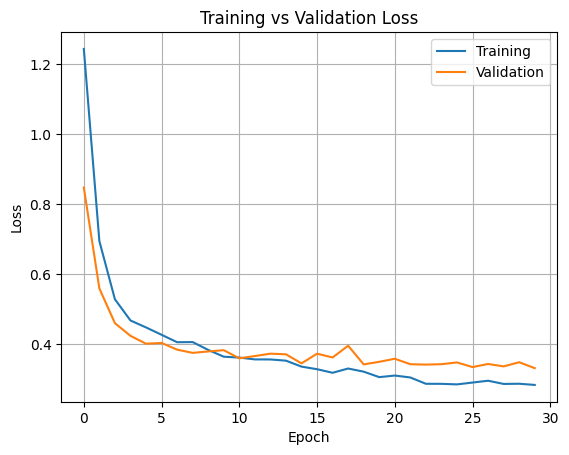

In [ ]:
plot_loss([baseline.training_loss, baseline.validation_loss], "Training vs Validation Loss", "baseline_loss")

- **Both training and validation loss decrease rapidly during the first few epochs. This indicates effective learning rate and stable optimization.**
- **After the first 10 epochs, the curves starts to flatten and the validation loss starts to converge. Training continues its steady decrease**
- **There is a small gap between validation and training loss. This suggests good generalization and no strong signs of overfitting.**
- **The slight oscillations in validation loss toward later epochs are expected in a small-dataset regime and indicate that the model is near convergence.**

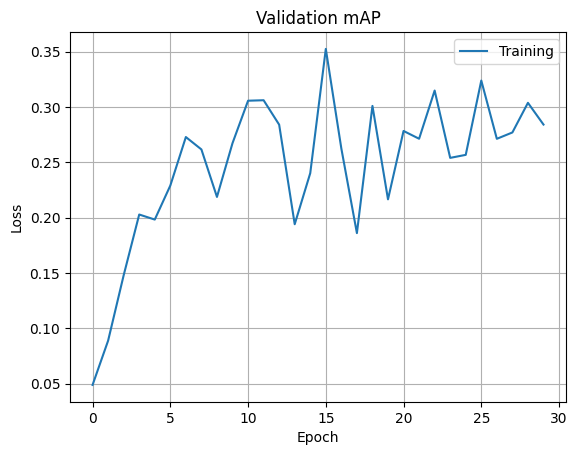

In [ ]:
plot_loss([baseline.validation_mAP], "Validation mAP", "baseline_map")

- **The validation map increases in the first few epochs, showing the Tiny-DETR quickly learns meaningful object representations.**
- **It reaches its peak at around the 15th epoch with a validation mAP of 0.35.**
- **mAP fluctuates than following a smooth monotically improvement. These oscillations potentially reflect to the sensitive nature of the metric used across individual samples.**
- **Overall, mAP aligns with the general behavior of the of the loss curves.**

In [ ]:
y_pred_base = cxcywh_to_xyxy(y_preds_baseline, 512, 512)

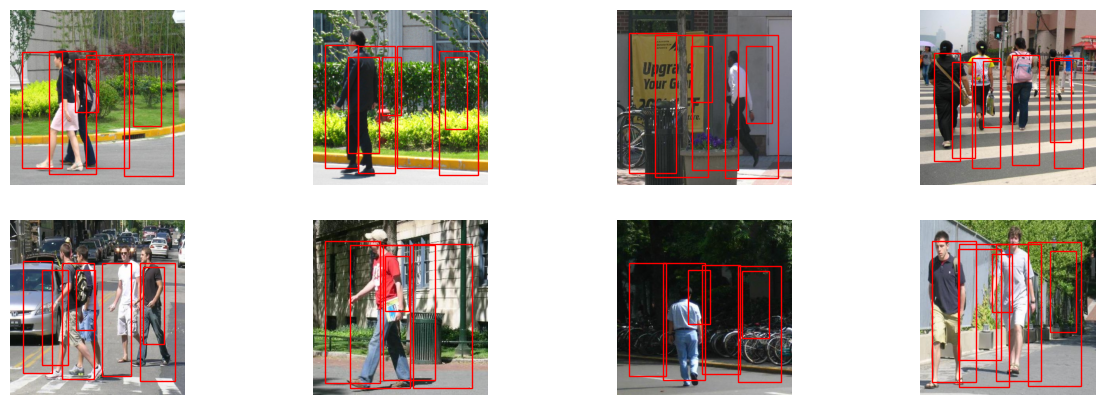

In [ ]:
show_images(X_test, y_pred_base, 8, 4, figsize=(15,5), save=True, name="baseline_predicted")

### Depth Impact

#### Training

In [ ]:
depth_1, best_depth_1 = train(
    X = X_train_norm,
    y = y_train_norm,
    epochs = 20,
    batch_size = 16, # TEST WHICH IS BETTER 8 OR 16
    backbone_lr = 1e-5,
    transformer_lr = 1e-4,
    backbone = "MobileNetV2",
    hidden_size = 256,
    n_enc_layer = 1,
    n_dec_layer = 1,
    n_query = 100,
    n_classes = 1,
    lamb = 5,
    alpha = 0.1,
    filter_coef=0.2)

Epoch: 1, Training Loss: 1.2330997064709663, Validation Loss: 0.9240366816520691, Validation mAP: 0.02833569049835205, Time: 4.75s
Epoch: 2, Training Loss: 0.8230399042367935, Validation Loss: 0.7031528353691101, Validation mAP: 0.0975295901298523, Time: 4.72s
Epoch: 3, Training Loss: 0.6291591748595238, Validation Loss: 0.516934335231781, Validation mAP: 0.07032491266727448, Time: 4.76s
Epoch: 4, Training Loss: 0.5216447338461876, Validation Loss: 0.4439510107040405, Validation mAP: 0.18371456861495972, Time: 4.75s
Epoch: 5, Training Loss: 0.4618063233792782, Validation Loss: 0.45614273846149445, Validation mAP: 0.117209292948246, Time: 4.79s
Epoch: 6, Training Loss: 0.4420749321579933, Validation Loss: 0.454023614525795, Validation mAP: 0.25653937458992004, Time: 4.82s
Epoch: 7, Training Loss: 0.4337764233350754, Validation Loss: 0.45157380402088165, Validation mAP: 0.2421044260263443, Time: 4.81s
Epoch: 8, Training Loss: 0.42545800283551216, Validation Loss: 0.41570159792900085, Val

In [ ]:
depth_3, best_depth_3 = train(
    X = X_train_norm,
    y = y_train_norm,
    epochs = 45,
    batch_size = 16, # TEST WHICH IS BETTER 8 OR 16
    backbone_lr = 1e-5,
    transformer_lr = 1e-4,
    backbone = "MobileNetV2",
    hidden_size = 256,
    n_enc_layer = 3,
    n_dec_layer = 3,
    n_query = 100,
    n_classes = 1,
    lamb = 5,
    alpha = 0.1,
    filter_coef=0.2)

Epoch: 1, Training Loss: 1.2491157203912735, Validation Loss: 0.8814716935157776, Validation mAP: 0.10535993427038193, Time: 5.09s
Epoch: 2, Training Loss: 0.7403592318296432, Validation Loss: 0.5942539870738983, Validation mAP: 0.089476078748703, Time: 5.10s
Epoch: 3, Training Loss: 0.5521203652024269, Validation Loss: 0.4948412775993347, Validation mAP: 0.15384232997894287, Time: 5.15s
Epoch: 4, Training Loss: 0.48453114926815033, Validation Loss: 0.44178226590156555, Validation mAP: 0.158388152718544, Time: 5.11s
Epoch: 5, Training Loss: 0.45329052582383156, Validation Loss: 0.4374486654996872, Validation mAP: 0.24122488498687744, Time: 5.13s
Epoch: 6, Training Loss: 0.4277252294123173, Validation Loss: 0.46409772336483, Validation mAP: 0.2313779890537262, Time: 5.12s
Epoch: 7, Training Loss: 0.4484534077346325, Validation Loss: 0.4323362708091736, Validation mAP: 0.18114475905895233, Time: 5.12s
Epoch: 8, Training Loss: 0.42451633885502815, Validation Loss: 0.39126622676849365, Val

#### Model Saving + Loading

In [ ]:
save_model_class(depth_1, "depth_1")
save_model_class(depth_3, "depth_3")

In [ ]:
depth_1 = load_model(model_output_path + "depth_1.pth", "MobileNetV2", 256, 1, 1, 100, 1)
depth_3 = load_model(model_output_path + "depth_3.pth", "MobileNetV2", 256, 3, 3, 100, 1)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 139MB/s]


#### Testing

In [ ]:
mAP_depth_1, y_preds_depth_1 = test(depth_1, X_test_norm, y_test_norm, 16)

In [ ]:
print(mAP_depth_1)

0.1657944917678833


In [ ]:
mAP_depth_3, y_preds_depth_3 = test(depth_3, X_test_norm, y_test_norm, 16)

In [ ]:
print(mAP_depth_3)

0.176411971449852


#### Visualization

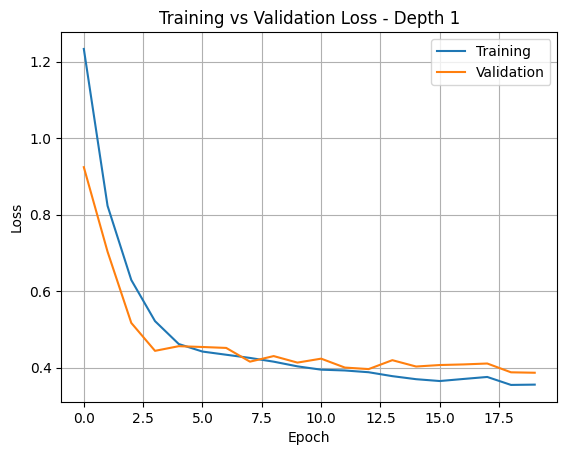

In [ ]:
plot_loss([depth_1.training_loss, depth_1.validation_loss], "Training vs Validation Loss - Depth 1", "depth_1_loss")

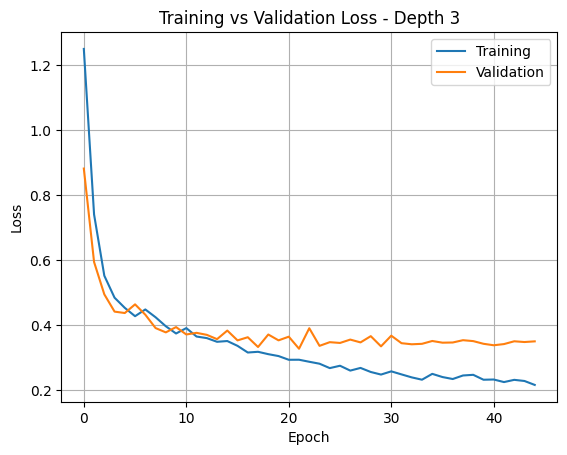

In [ ]:
plot_loss([depth_3.training_loss, depth_3.validation_loss], "Training vs Validation Loss - Depth 3", "depth_3_loss")

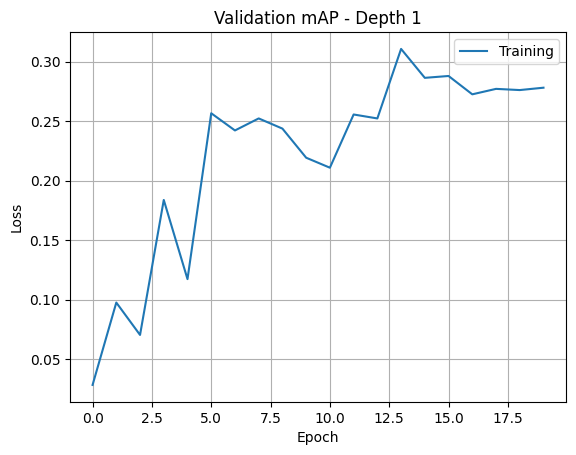

In [ ]:
plot_loss([depth_1.validation_mAP], "Validation mAP - Depth 1", "mAP_depth_1")

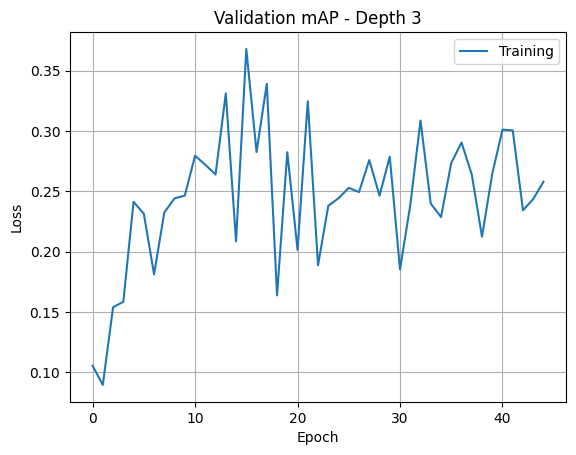

In [ ]:
plot_loss([depth_3.validation_mAP], "Validation mAP - Depth 3", "mAP_depth_3")

### Data Augmentation Impact

#### Training

In [ ]:
detr_aug, best_deter_aug = train(
    X = X_train_aug_norm,
    y = y_train_aug_norm,
    epochs = 30,
    batch_size = 16,
    backbone_lr = 1e-5,
    transformer_lr = 1e-4,
    backbone = "MobileNetV2",
    hidden_size = 256,
    n_enc_layer = 2,
    n_dec_layer = 2,
    n_query = 100,
    n_classes = 1,
    lamb = 5,
    alpha = 0.1,
    filter_coef=0.2)

Epoch: 1, Training Loss: 0.7393908060115316, Validation Loss: 0.4778793007135391, Validation mAP: 0.2041705846786499, Time: 14.96s
Epoch: 2, Training Loss: 0.45054120602815045, Validation Loss: 0.4271176606416702, Validation mAP: 0.26669225096702576, Time: 15.03s
Epoch: 3, Training Loss: 0.411750043215959, Validation Loss: 0.3961167633533478, Validation mAP: 0.16077831387519836, Time: 15.07s
Epoch: 4, Training Loss: 0.3820564733899158, Validation Loss: 0.3833919167518616, Validation mAP: 0.31398531794548035, Time: 14.90s
Epoch: 5, Training Loss: 0.36310160289640014, Validation Loss: 0.3639022409915924, Validation mAP: 0.25182053446769714, Time: 14.84s
Epoch: 6, Training Loss: 0.36159318815106933, Validation Loss: 0.37115852534770966, Validation mAP: 0.2731255888938904, Time: 14.92s
Epoch: 7, Training Loss: 0.33595411414685455, Validation Loss: 0.35084637999534607, Validation mAP: 0.3612425923347473, Time: 14.99s
Epoch: 8, Training Loss: 0.32964180345120636, Validation Loss: 0.352420657

#### Model Saving + Loading

In [ ]:
save_model_class(detr_aug, "detr_aug")

In [ ]:
detr_aug = load_model(model_output_path + "detr_aug.pth", "MobileNetV2", 256, 2, 2, 100, 1)

#### Testing

In [ ]:
mAP_detr_aug, y_preds_detr_aug = test(detr_aug, X_test_norm, y_test_norm, 16)

In [ ]:
print(f"mAP: {mAP_detr_aug:.2f}")

mAP: 0.51


#### Visualization

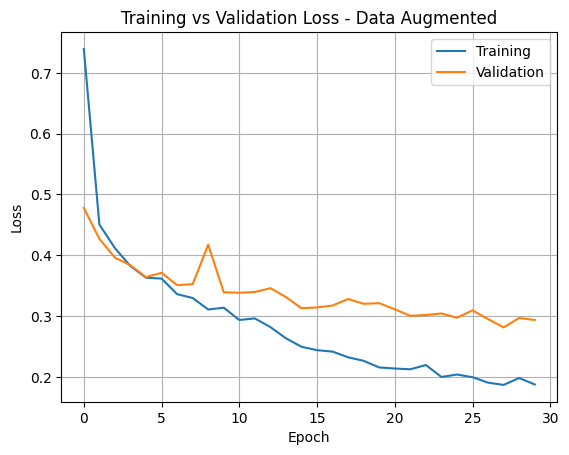

In [ ]:
plot_loss([detr_aug.training_loss, detr_aug.validation_loss], "Training vs Validation Loss - Data Augmented", "detr_aug_loss")

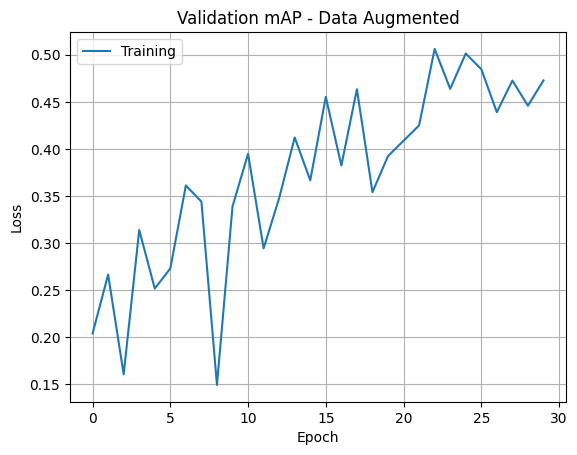

In [ ]:
plot_loss([detr_aug.validation_mAP], "Validation mAP - Data Augmented", "detr_aug_mAP")

In [ ]:
y_pred_best_model = cxcywh_to_xyxy(y_preds_detr_aug, 512, 512)

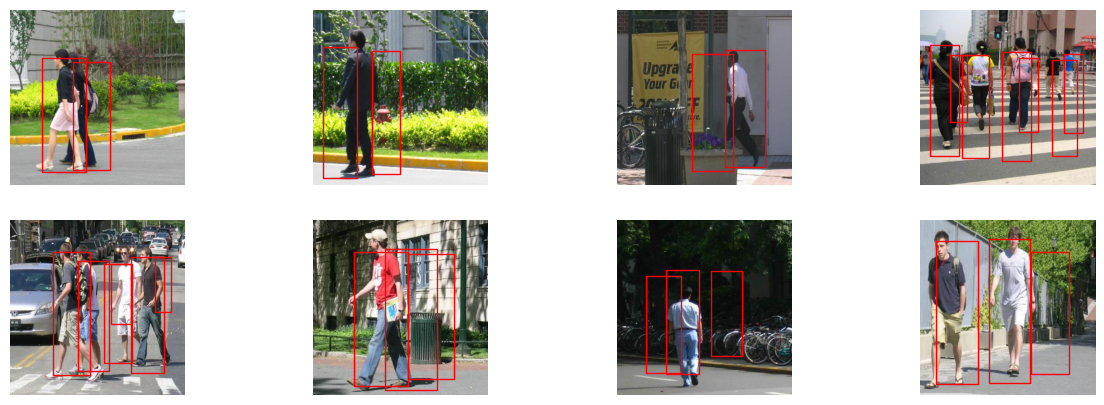

In [ ]:
show_images(X_test, y_pred_best_model, 8, 4, figsize=(15,5), save=True, name="best_model_predicted")

### Backbone Comparsion

#### Training

In [ ]:
detr_aug_resnet, best_aug_resnet = train(
    X = X_train_aug_norm,
    y = y_train_aug_norm,
    epochs = 30,
    batch_size = 16,
    backbone_lr = 1e-5,
    transformer_lr = 1e-4,
    backbone = "ResNet18",
    hidden_size = 256,
    n_enc_layer = 2,
    n_dec_layer = 2,
    n_query = 100,
    n_classes = 1,
    lamb = 5,
    alpha = 0.1,
    filter_coef=0.2)

Epoch: 1, Training Loss: 0.7618010886337446, Validation Loss: 0.4680998623371124, Validation mAP: 0.17893564701080322, Time: 11.32s
Epoch: 2, Training Loss: 0.44073735242304596, Validation Loss: 0.3880334943532944, Validation mAP: 0.19939099252223969, Time: 11.38s
Epoch: 3, Training Loss: 0.39434613222661224, Validation Loss: 0.35671791434288025, Validation mAP: 0.33311426639556885, Time: 11.61s
Epoch: 4, Training Loss: 0.34906311138816504, Validation Loss: 0.3873023986816406, Validation mAP: 0.30708062648773193, Time: 11.53s
Epoch: 5, Training Loss: 0.32603981313498126, Validation Loss: 0.31283999979496, Validation mAP: 0.3536941111087799, Time: 11.41s
Epoch: 6, Training Loss: 0.31861203261043713, Validation Loss: 0.34024912118911743, Validation mAP: 0.2879137694835663, Time: 11.41s
Epoch: 7, Training Loss: 0.292951414766519, Validation Loss: 0.3412442207336426, Validation mAP: 0.2552064061164856, Time: 11.37s
Epoch: 8, Training Loss: 0.2767067409080008, Validation Loss: 0.34641259908

#### Model Saving + Loading

In [ ]:
save_model_class(detr_aug_resnet, "detr_aug_resnet")

In [ ]:
detr_aug_resnet = load_model(model_output_path + "detr_aug_resnet.pth", "ResNet18", 256, 2, 2, 100, 1)

#### Testing

In [ ]:
mAP_deter_aug_resnet, y_preds_deter_aug_resnet = test(detr_aug_resnet, X_test_norm, y_test_norm, 16)

In [ ]:
print(mAP_deter_aug_resnet)

0.5017655491828918


#### Visualization

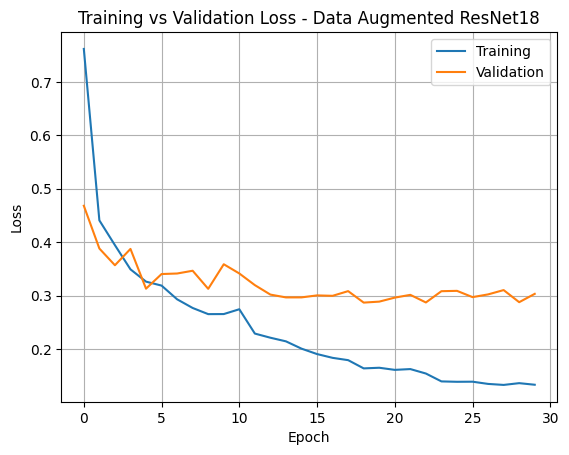

In [ ]:
plot_loss([detr_aug_resnet.training_loss, detr_aug_resnet.validation_loss], "Training vs Validation Loss - Data Augmented ResNet18", "detr_aug_resnet_loss")

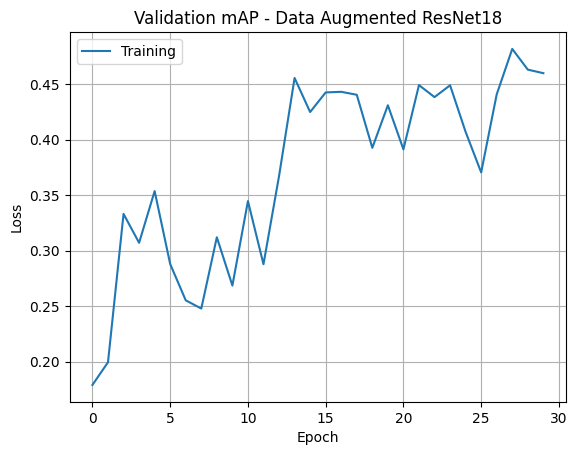

In [ ]:
plot_loss([detr_aug_resnet.validation_mAP], "Validation mAP - Data Augmented ResNet18", "detr_aug_resnet_mAP")

### Object Queries Change

#### Training

In [ ]:
detr_aug_query_50, best_deter_aug_query_50 = train(
    X = X_train_aug_norm,
    y = y_train_aug_norm,
    epochs = 30,
    batch_size = 16,
    backbone_lr = 1e-5,
    transformer_lr = 1e-4,
    backbone = "MobileNetV2",
    hidden_size = 256,
    n_enc_layer = 2,
    n_dec_layer = 2,
    n_query = 50,
    n_classes = 1,
    lamb = 5,
    alpha = 0.1,
    filter_coef=0.2)

Epoch: 1, Training Loss: 0.8571299444074216, Validation Loss: 0.5206785500049591, Validation mAP: 0.17190034687519073, Time: 14.76s
Epoch: 2, Training Loss: 0.4957781304483828, Validation Loss: 0.48223480582237244, Validation mAP: 0.2345590591430664, Time: 14.95s
Epoch: 3, Training Loss: 0.4629117237484973, Validation Loss: 0.4441150426864624, Validation mAP: 0.193800151348114, Time: 14.91s
Epoch: 4, Training Loss: 0.43789872915848443, Validation Loss: 0.42031313478946686, Validation mAP: 0.24894170463085175, Time: 14.79s
Epoch: 5, Training Loss: 0.4054895950400311, Validation Loss: 0.40137653052806854, Validation mAP: 0.25361236929893494, Time: 14.77s
Epoch: 6, Training Loss: 0.3939448504344277, Validation Loss: 0.3655281662940979, Validation mAP: 0.337213397026062, Time: 14.80s
Epoch: 7, Training Loss: 0.3781357899956081, Validation Loss: 0.3716341555118561, Validation mAP: 0.4206349849700928, Time: 14.81s
Epoch: 8, Training Loss: 0.35836672912473266, Validation Loss: 0.3854832947254

In [ ]:
detr_aug_query_25, best_deter_aug_query_25 = train(
    X = X_train_aug_norm,
    y = y_train_aug_norm,
    epochs = 30,
    batch_size = 16,
    backbone_lr = 1e-5,
    transformer_lr = 1e-4,
    backbone = "MobileNetV2",
    hidden_size = 256,
    n_enc_layer = 2,
    n_dec_layer = 2,
    n_query = 25,
    n_classes = 1,
    lamb = 5,
    alpha = 0.1,
    filter_coef=0.2)

Epoch: 1, Training Loss: 0.8540838101635808, Validation Loss: 0.571887344121933, Validation mAP: 0.13114222884178162, Time: 14.76s
Epoch: 2, Training Loss: 0.5760761188424152, Validation Loss: 0.5213750600814819, Validation mAP: 0.21305646002292633, Time: 14.87s
Epoch: 3, Training Loss: 0.5396597139213396, Validation Loss: 0.48406536877155304, Validation mAP: 0.2340601533651352, Time: 14.90s
Epoch: 4, Training Loss: 0.509763100872869, Validation Loss: 0.5074677169322968, Validation mAP: 0.2559140622615814, Time: 14.78s
Epoch: 5, Training Loss: 0.4857041265653527, Validation Loss: 0.4781305342912674, Validation mAP: 0.2569560706615448, Time: 14.63s
Epoch: 6, Training Loss: 0.4859924122043278, Validation Loss: 0.45704948902130127, Validation mAP: 0.2501315474510193, Time: 14.60s
Epoch: 7, Training Loss: 0.4460966353831084, Validation Loss: 0.4516243636608124, Validation mAP: 0.202256441116333, Time: 14.79s
Epoch: 8, Training Loss: 0.4197963333648184, Validation Loss: 0.4211706817150116, 

#### Model Saving + Loading

In [ ]:
save_model_class(detr_aug_query_50, "detr_aug_query_50")

In [ ]:
save_model_class(detr_aug_query_25, "detr_aug_query_25")

In [ ]:
detr_aug_query_50 = load_model(model_output_path + "detr_aug_query_50.pth", "MobileNetV2", 256, 2, 2, 50, 1)
detr_aug_query_25 = load_model(model_output_path + "detr_aug_query_25.pth", "MobileNetV2", 256, 2, 2, 25, 1)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 219MB/s]


#### Testing

In [ ]:
mAP_deter_aug_query_50, y_preds_deter_aug_query_50 = test(detr_aug_query_50, X_test_norm, y_test_norm, 16)

In [ ]:
print(mAP_deter_aug_query_50)

0.4463072717189789


In [ ]:
mAP_deter_aug_query_25, y_preds_deter_aug_query_25 = test(detr_aug_query_25, X_test_norm, y_test_norm, 16)

In [ ]:
print(mAP_deter_aug_query_25)

0.44722598791122437


#### Visualization

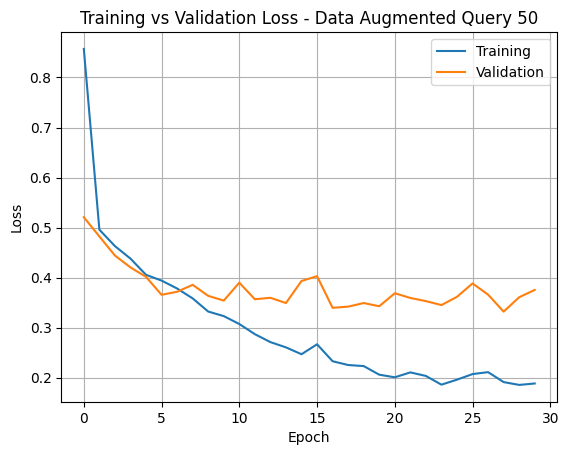

In [ ]:
plot_loss([detr_aug_query_50.training_loss, detr_aug_query_50.validation_loss], "Training vs Validation Loss - Data Augmented Query 50", "detr_aug_query_50_loss")

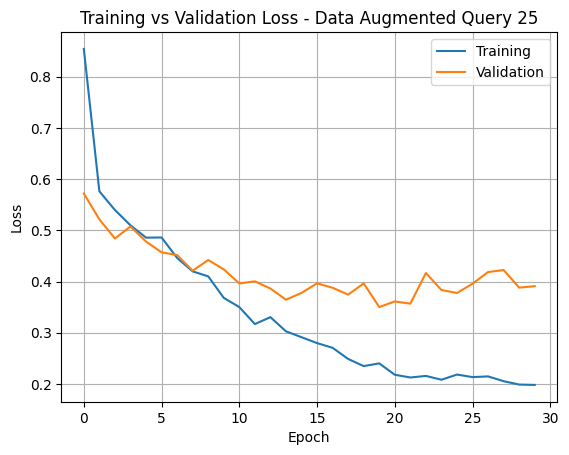

In [ ]:
plot_loss([detr_aug_query_25.training_loss, detr_aug_query_25.validation_loss], "Training vs Validation Loss - Data Augmented Query 25", "detr_aug_query_25_loss")

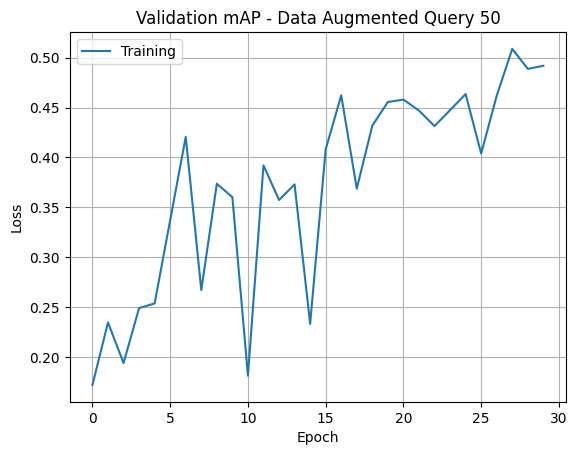

In [ ]:
plot_loss([detr_aug_query_50.validation_mAP], "Validation mAP - Data Augmented Query 50", "detr_aug_query_50_mAP")

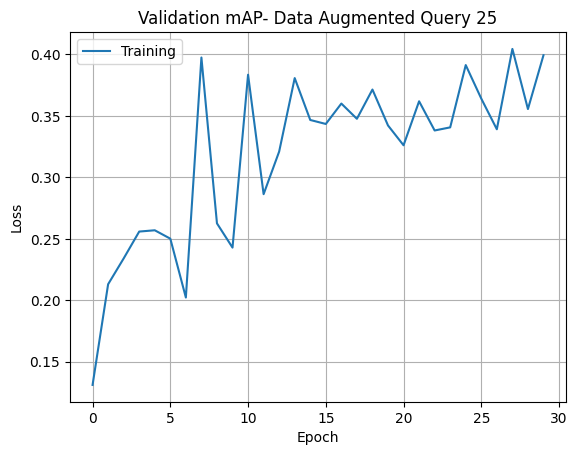

In [ ]:
plot_loss([detr_aug_query_25.validation_mAP], "Validation mAP- Data Augmented Query 25", "detr_aug_query_25_mAP")

## Resources

- **Offline Data Augmentation: https://docs.nvidia.com/tao/tao-toolkit/latest/text/data_services/augment.html**
- **ColorJitter: https://docs.pytorch.org/vision/main/generated/torchvision.transforms.ColorJitter.html**
- **Positional Encoding in Transformers: https://www.geeksforgeeks.org/nlp/positional-encoding-in-transformers/**
- **Transformer: https://docs.pytorch.org/docs/stable/generated/torch.nn.Transformer.html**